# GDP and life expectancy

Richer countries can afford to invest more on healthcare, on work and road safety, and other measures that reduce mortality. On the other hand, richer countries may have less healthy lifestyles. Is there any relation between the wealth of a country and the life expectancy of its inhabitants?

The following analysis checks whether there is any correlation between the total gross domestic product (GDP) of a country in 2013 and the life expectancy of people born in that country in 2013.

## Getting the data

Two datasets of the World Bank are considered. One dataset, available at <http://data.worldbank.org/indicator/NY.GDP.MKTP.CD>, lists the GDP of the world's countries in current US dollars, for various years. The use of a common currency allows us to compare GDP values across countries. The other dataset, available at <http://data.worldbank.org/indicator/SP.DYN.LE00.IN>, lists the life expectancy of the world's countries. The datasets were downloaded as CSV files in March 2016.

In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

import pandas as pd

YEAR = 2013
GDP_INDICATOR = 'NY.GDP.MKTP.CD'
gdpReset = pd.read_csv('WB GDP 2013.csv')

LIFE_INDICATOR = 'SP.DYN.LE00.IN'
lifeReset = pd.read_csv('WB LE 2013.csv')
lifeReset.head()

,country,year,SP.DYN.LE00.IN
0,Arab World,2013,70.631305
1,Caribbean small states,2013,71.901964
2,Central Europe and the Baltics,2013,76.127583
3,East Asia & Pacific (all income levels),2013,74.604619
4,East Asia & Pacific (developing only),2013,73.657617


## Cleaning the data

While inspecting the data with `head()` and `tail()` shows that, it was observed that the first 34 rows are aggregated data, that is they are country groups. Individual countries starts in row number 34
It was observed that GDP and life expectancy values are missing for some countries.

Therefore wwe have to clean the data by removing the first 34 rows and removing rows with unavailable values.

In [2]:
gdpCountries = gdpReset[34:].dropna()
lifeCountries = lifeReset[34:].dropna()

## Transforming the data

The World Bank reports GDP in US dollars and cents. To make the data easier to read, the GDP is converted to millions of British pounds (the author's local currency) with the following auxiliary functions, using the average 2013 dollar-to-pound conversion rate provided by <http://www.ukforex.co.uk/forex-tools/historical-rate-tools/yearly-average-rates>. 

In [3]:
def roundToMillions (value):
    return round(value / 1000000)

def usdToGBP (usd):
    return usd / 1.564768

GDP = 'GDP (£m)'
gdpCountries[GDP] = gdpCountries[GDP_INDICATOR].apply(usdToGBP).apply(roundToMillions)
gdpCountries.head()

,country,year,NY.GDP.MKTP.CD,GDP (£m)
34,Afghanistan,2013,2.045894e+10,13075
35,Albania,2013,1.278103e+10,8168
36,Algeria,2013,2.097035e+11,134016
38,Andorra,2013,3.249101e+09,2076
39,Angola,2013,1.383568e+11,88420


The unnecessary columns can be dropped.

In [4]:
COUNTRY = 'country'
headings = [COUNTRY, GDP]
gdpClean = gdpCountries[headings]
gdpClean.head()

,country,GDP (£m)
34,Afghanistan,13075
35,Albania,8168
36,Algeria,134016
38,Andorra,2076
39,Angola,88420


The World Bank reports the life expectancy with several decimal places. After rounding, the original column is discarded.

In [5]:
LIFE = 'Life expectancy (years)'
lifeCountries[LIFE] = lifeCountries[LIFE_INDICATOR].apply(round)
headings = [COUNTRY, LIFE]
lifeClean = lifeCountries[headings]
lifeClean.head()

,country,Life expectancy (years)
34,Afghanistan,60
35,Albania,78
36,Algeria,75
39,Angola,52
40,Antigua and Barbuda,76


## Combining the data

The tables are combined through an inner join on the common 'country' column. 

In [7]:
gdpVsLife = pd.merge(gdpClean, lifeClean, on=COUNTRY, how='inner')
gdpVsLife.head()

,country,GDP (£m),Life expectancy (years)
0,Afghanistan,13075,60
1,Albania,8168,78
2,Algeria,134016,75
3,Angola,88420,52
4,Antigua and Barbuda,767,76


## Calculating the correlation

To measure if the life expectancy and the GDP grow together, the Spearman rank correlation coefficient is used. It is a number from -1 (perfect inverse rank correlation: if one indicator increases, the other decreases) to 1 (perfect direct rank correlation: if one indicator increases, so does the other), with 0 meaning there is no rank correlation. A perfect correlation doesn't imply any cause-effect relation between the two indicators. A p-value below 0.05 means the correlation is statistically significant.

In [8]:
from scipy.stats import spearmanr

gdpColumn = gdpVsLife[GDP]
lifeColumn = gdpVsLife[LIFE]
(correlation, pValue) = spearmanr(gdpColumn, lifeColumn)
print('The correlation is', correlation)
print('The p-value is', pValue)

if pValue < 0.05:
    print('It is statistically significant.')
else:
    print('It is not statistically significant.')

The correlation is 0.5010232389671027
The p-value is 3.2614057033600436e-13
It is statistically significant.


The value shows a direct correlation, i.e. richer countries tend to have longer life expectancy, but it is not very strong.

## Showing the data

Measures of correlation can be misleading, so it is best to see the overall picture with a scatterplot. The GDP axis uses a logarithmic scale to better display the vast range of GDP values, from a few million to several billion (million of million) pounds.

<AxesSubplot:xlabel='GDP (£m)', ylabel='Life expectancy (years)'>

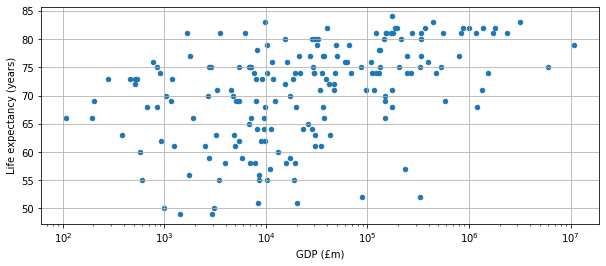

In [9]:
%matplotlib inline
gdpVsLife.plot(x=GDP, y=LIFE, kind='scatter', grid=True, logx=True, figsize=(10, 4))

The plot shows there is no clear correlation: there are rich countries with low life expectancy, poor countries with high expectancy, and countries with around 10 thousand (10<sup>4</sup>) million pounds GDP have almost the full range of values, from below 50 to over 80 years. Towards the lower and higher end of GDP, the variation diminishes. Above 40 thousand million pounds of GDP (3rd tick mark to the right of 10<sup>4</sup>), most countries have an expectancy of 70 years or more, whilst below that threshold most countries' life expectancy is below 70 years. 

Comparing the 10 poorest countries and the 10 countries with the lowest life expectancy shows that total GDP is a rather crude measure. The population size should be taken into account for a more precise definiton of what 'poor' and 'rich' means. Furthermore, looking at the countries below, droughts and internal conflicts may also play a role in life expectancy. 

In [10]:
# the 10 countries with lowest GDP
gdpVsLife.sort_values(GDP).head(10)

,country,GDP (£m),Life expectancy (years)
87,Kiribati,108,66
141,Sao Tome and Principe,195,66
111,"Micronesia, Fed. Sts.",202,69
168,Tonga,277,73
37,Comoros,383,63
157,St. Vincent and the Grenadines,461,73
140,Samoa,509,73
180,Vanuatu,512,72
65,Grenada,538,73
60,"Gambia, The",578,60


In [11]:
# the 10 countries with lowest life expectancy
gdpVsLife.sort_values(LIFE).head(10)

,country,GDP (£m),Life expectancy (years)
95,Lesotho,1418,49
160,Swaziland,2916,49
32,Central African Republic,983,50
146,Sierra Leone,3092,50
33,Chad,8276,51
41,Cote d'Ivoire,19998,51
3,Angola,88420,52
124,Nigeria,329100,52
30,Cameroon,18896,55
153,South Sudan,8473,55


## Conclusions

To sum up, there is no strong correlation between a country's wealth and the life expectancy of its inhabitants: there is often a wide variation of life expectancy for countries with similar GDP, countries with the lowest life expectancy are not the poorest countries, and countries with the highest expectancy are not the richest countries. Nevertheless there is some relationship, because the vast majority of countries with a life expectancy below 70 years is on the left half of the scatterplot.

Using the [NY.GDP.PCAP.PP.CD](http://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD) indicator, GDP per capita in current 'international dollars', would make for a better like-for-like comparison between countries, because it would take population and purchasing power into account. Using more specific data, like expediture on health, could also lead to a better analysis.

## NOW IS YOUR TURN


## GOOD LUCK!

Activity
Extend the project
Make a copy of the Project Notebook: GDP and Life expectancy and change it to answer one or more of the following questions:

To what extent do the ten countries with the highest GDP coincide with the ten countries with the longest life expectancy?

Which are the two countries in the right half of the plot (higher GDP) with life expectancy below 60 years?

What factors could explain their lower life expectancy compared to countries with similar GDP? Hint: use the filtering techniques you learned in Week 2 to find the two countries.

Redo the analysis using the countries’ GDP per capita (i.e. per inhabitant) instead of their total GDP. If you’ve done the workbook task, you already have a column with the population data.

Hint: write an expression involving the GDP and population columns, as you learned in Calculating over columns in previous modules. Think about the units in which you display GDP per capita.

Redo the analysis using the indicator suggested at the end of the project notebook.
Create your own project Create a completely new project and choose another two of the hundreds of World Bank indicators and see if there is any correlation between them. If there is a choice of similar indicators, choose one that leads to meaningful comparisons between countries.

Look at the results you obtained and take a few moments to assess how they differ from mine.

Below is ten countries with the highest GDP

In [14]:
highestGDP = gdpVsLife.sort_values(GDP).tail(10)
highestGDP


,country,GDP (£m),Life expectancy (years)
75,India,1189826,68
138,Russian Federation,1328647,71
81,Italy,1363486,82
23,Brazil,1528714,74
176,United Kingdom,1733354,81
58,France,1795953,82
62,Germany,2393529,81
83,Japan,3143957,83
35,China,6065182,75
177,United States,10715999,79


Below is ten countries with the longest life expectancy

In [13]:
longestLife = gdpVsLife.sort_values(LIFE).tail(10)
longestLife

,country,GDP (£m),Life expectancy (years)
80,Israel,186870,82
81,Italy,1363486,82
99,Luxembourg,39491,82
154,Spain,875057,82
58,France,1795953,82
161,Sweden,369858,82
74,Iceland,9827,83
162,Switzerland,437713,83
83,Japan,3143957,83
72,"Hong Kong SAR, China",176220,84


countries with both highest GDP and longest life expectancy is gotten by merging the countries with highest GDP and countries with longest life expectancy. this is shown below

In [16]:
pd.merge(highestGDP, longestLife, how='inner', on='country')

,country,GDP (£m)_x,Life expectancy (years)_x,GDP (£m)_y,Life expectancy (years)_y
0,Italy,1363486,82,1363486,82
1,France,1795953,82,1795953,82
2,Japan,3143957,83,3143957,83


From the figure above we can say that the countries with highest GDPand longest life expectancy is Italy, France and Japan

In [18]:
# right half of the graph is above 10**5
# Therefore, to get the countries in the right half of the plot 
# (higher GDP) with life expectancy below 60 years we use the comparison operator and bitwise opeartor '&'

gdpVsLife[(gdpVsLife[GDP] > 10**5) & (gdpVsLife[LIFE] < 60)]

,country,GDP (£m),Life expectancy (years)
124,Nigeria,329100,52
152,South Africa,234056,57


it was observed that Nigeria and South Africa are the two countries in the right half of the plot (higher GDP) and with life expectancy below 60 years



In [20]:
# countries in the right half of the plot (higher GDP) and with  high life expectancy of above 75years

gdpVsLife[(gdpVsLife[GDP] > 10**6) & (gdpVsLife[LIFE] >= 75)]

,country,GDP (£m),Life expectancy (years)
31,Canada,1175231,81
35,China,6065182,75
58,France,1795953,82
62,Germany,2393529,81
81,Italy,1363486,82
83,Japan,3143957,83
176,United Kingdom,1733354,81
177,United States,10715999,79


In [49]:
gdpVsLife[(gdpVsLife[GDP] > 175000) & (gdpVsLife[GDP] < 375000)].sort_values(LIFE)

,country,GDP (£m),Life expectancy (years)
124,Nigeria,329100,52
152,South Africa,234056,57
36,Colombia,242888,74
165,Thailand,268517,74
104,Malaysia,206639,75
77,"Iran, Islamic Rep.",326963,75
133,Poland,334912,77
175,United Arab Emirates,247444,77
46,Denmark,214650,80
15,Belgium,333214,80


Most countries with GDP Above 40 thousand million pounds  have an expectancy of 70 years or more expect two countries Nigeria and South Africa. FRom the figure above we observe a great difference in life expectancy exists between South Africa and Colombia

The lower life expectancy of South Africa and Nigeria maybe as a result of poor socio-economic status in Africa.

# Analysis using the countries’ GDP per capita (i.e. per inhabitant) 

In [21]:
import pandas as pd

YEAR = 2013
GDP_INDICATOR = 'NY.GDP.MKTP.CD'
gdpReset = pd.read_csv('WB GDP 2013.csv')

LIFE_INDICATOR = 'SP.DYN.LE00.IN'
lifeReset = pd.read_csv('WB LE 2013.csv')

POP_INDICATOR = 'SP.POP.TOTL'
popReset = pd.read_csv("WB POP 2013.csv")
popReset.head()

,country,year,SP.POP.TOTL
0,Arab World,2013,3.770967e+08
1,Caribbean small states,2013,6.975819e+06
2,Central Europe and the Baltics,2013,1.037137e+08
3,East Asia & Pacific (all income levels),2013,2.248867e+09
4,East Asia & Pacific (developing only),2013,2.006073e+09


# Cleaning data 

While inspecting the data with `head()` and `tail()` shows that, it was observed that the first 34 rows are aggregated data, that is they are country groups. Individual countries starts in row number 34
It was observed that GDP and life expectancy values are missing for some countries.

Therefore wwe have to clean the data by removing the first 34 rows and removing rows with unavailable values.

In [22]:
gdpCountries = gdpReset[34:].dropna()
lifeCountries = lifeReset[34:].dropna()
popCountries = popReset[34:].dropna()



# Transform data

The World Bank reports GDP in US dollars and cents. in order to make the data easy to read we then converted the GDP to millions of British pounds, using the average 2013 dollar-to-pound conversion rate provided by http://www.ukforex.co.uk/forex-tools/historical-rate-tools/yearly-average-rates.

In [23]:
def roundToMillions (value):
    return round(value / 1000000)

def usdToGBP (usd):
    return usd / 1.564768

GDP = 'GDP (£m)'
gdpCountries[GDP] = gdpCountries[GDP_INDICATOR].apply(usdToGBP)
gdpCountries.head()

,country,year,NY.GDP.MKTP.CD,GDP (£m)
34,Afghanistan,2013,2.045894e+10,1.307474e+10
35,Albania,2013,1.278103e+10,8.168003e+09
36,Algeria,2013,2.097035e+11,1.340157e+11
38,Andorra,2013,3.249101e+09,2.076410e+09
39,Angola,2013,1.383568e+11,8.842001e+10


We need to need remove the column we don't need and focus the the main data

In [24]:
COUNTRY = 'country'
headings = [COUNTRY, GDP]
gdpClean = gdpCountries[headings]
gdpClean.head()

,country,GDP (£m)
34,Afghanistan,1.307474e+10
35,Albania,8.168003e+09
36,Algeria,1.340157e+11
38,Andorra,2.076410e+09
39,Angola,8.842001e+10


In [25]:
POP = ('Population')
popCountries[POP] = popCountries[POP_INDICATOR]

In [26]:
headings = [COUNTRY, POP]
popClean = popCountries[headings]
popClean.head()

,country,Population
34,Afghanistan,30682500.0
35,Albania,2897366.0
36,Algeria,38186135.0
37,American Samoa,55302.0
38,Andorra,75902.0


In [27]:
gdpVspop = pd.merge(gdpClean, popClean, on=COUNTRY, how='inner')
gdpVspop.head()

,country,GDP (£m),Population
0,Afghanistan,1.307474e+10,30682500.0
1,Albania,8.168003e+09,2897366.0
2,Algeria,1.340157e+11,38186135.0
3,Andorra,2.076410e+09,75902.0
4,Angola,8.842001e+10,23448202.0


In [28]:
GDP_PC = 'GDP per capita (£)'
gdpVspop[GDP_PC] = gdpVspop[GDP]/gdpVspop[POP]


From the data, it was observed that the life expectancy are in decimals. Inorder to make the data easy to read, we need to round it up nearest whole number.

In [30]:
LIFE = 'Life expectancy (years)'
lifeCountries[LIFE] = lifeCountries[LIFE_INDICATOR].apply(round)
headings = [COUNTRY, LIFE]
lifeClean = lifeCountries[headings]
lifeClean.head()

,country,Life expectancy (years)
34,Afghanistan,60
35,Albania,78
36,Algeria,75
39,Angola,52
40,Antigua and Barbuda,76


In [31]:
gdpPC = gdpVspop[[COUNTRY, GDP_PC]]
gdpPC.head(10)

,country,GDP per capita (£)
0,Afghanistan,426.130296
1,Albania,2819.113275
2,Algeria,3509.539059
3,Andorra,27356.465977
4,Angola,3770.865438
5,Antigua and Barbuda,8526.557929
6,Argentina,9230.164249
7,Armenia,2375.322682
8,Australia,43219.041631
9,Austria,32310.095686


In [32]:
gdpPCVslife = pd.merge(gdpPC, lifeClean, on=COUNTRY, how='inner')
gdpPCVslife.head()

,country,GDP per capita (£),Life expectancy (years)
0,Afghanistan,426.130296,60
1,Albania,2819.113275,78
2,Algeria,3509.539059,75
3,Angola,3770.865438,52
4,Antigua and Barbuda,8526.557929,76


In [33]:
highestGDP_PC = gdpPCVslife.sort_values(GDP_PC).tail(10)
highestGDP_PC

,country,GDP per capita (£),Life expectancy (years)
147,Singapore,35775.116215,82
46,Denmark,38228.434840,80
161,Sweden,38525.356617,82
7,Australia,43219.041631,82
162,Switzerland,54109.806014,83
18,Bermuda,54799.219702,81
100,"Macao SAR, China",57728.570070,80
136,Qatar,61400.154129,78
125,Norway,65717.255651,81
99,Luxembourg,72679.553121,82


In [34]:
longestlife = gdpPCVslife.sort_values(LIFE).tail(10)
longestlife

,country,GDP per capita (£),Life expectancy (years)
80,Israel,23186.312537,82
81,Italy,22636.504333,82
99,Luxembourg,72679.553121,82
154,Spain,18769.979874,82
58,France,27242.155028,82
161,Sweden,38525.356617,82
74,Iceland,30351.623396,83
162,Switzerland,54109.806014,83
83,Japan,24689.735513,83
72,"Hong Kong SAR, China",24517.497099,84


countries with both the highest GDP per capital and longest life expectancy are shown below 

In [36]:
pd.merge(highestGDP_PC, longestlife, how='inner', on='country')

,country,GDP per capita (£)_x,Life expectancy (years)_x,GDP per capita (£)_y,Life expectancy (years)_y
0,Sweden,38525.356617,82,38525.356617,82
1,Switzerland,54109.806014,83,54109.806014,83
2,Luxembourg,72679.553121,82,72679.553121,82


In [50]:
from scipy.stats import spearmanr

gdppcColumn = gdpPCVslife[GDP_PC]
lifeColumn = gdpPCVslife[LIFE]
(r, p) = spearmanr(gdppcColumn, lifeColumn)
print('The correlation coefficient is', r)
print('The p-value is', p)

if p < 0.05:
    print('This result is statistically significant.')
else:
    print('This result is not statistically significant.')

The correlation coefficient is 0.8502554597715132
The p-value is 3.598395374072683e-53
This result is statistically significant.


The value 0.8502554597715132 shows a strong correlation

<AxesSubplot:xlabel='GDP per capita (£)', ylabel='Life expectancy (years)'>

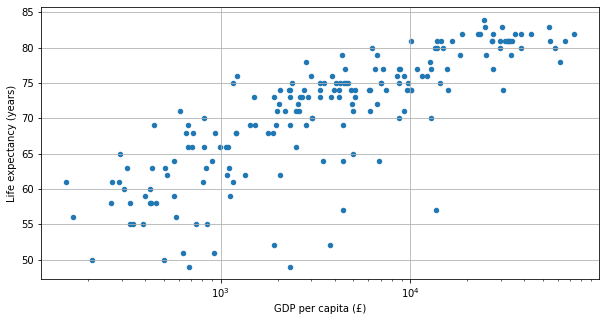

In [51]:

%matplotlib inline

gdpPCVslife.plot(x=GDP_PC, y=LIFE, grid=True, kind='scatter', logx=True, figsize=(10,5))

from the graph above it is observed that that the life expectancy increases as the GDP per capita increases. Therefore, there's a strong correlation between both